In [1]:
# import libraries
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

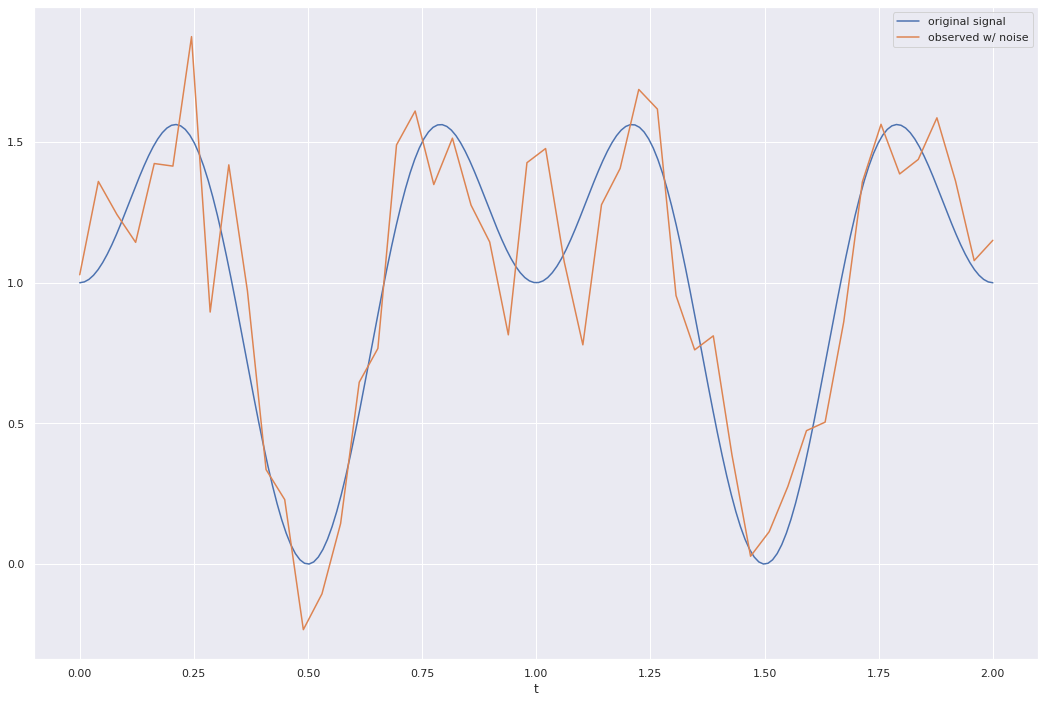

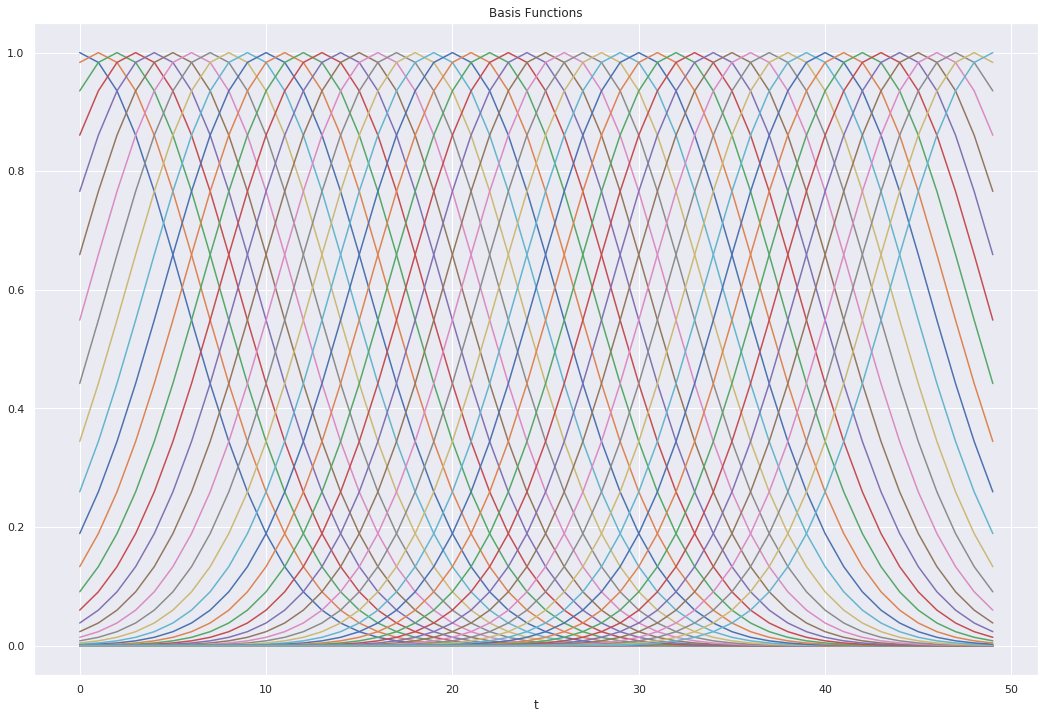

In [2]:
"""
    Generate a linear regression example
    
    Here we create a random sinusoid with noise and try to fit a regression model
    
    We use a collection of gaussian kernels as our basis functions
"""
# set seed
np.random.seed(999)

# generate a signal
t = np.linspace(0,2,200)
x = np.sin(np.pi*t)**2 + np.sin(2*np.pi*t)**2 + np.cos(2*np.pi*t)

# create gaussian noise
var = 5e-2
n = np.random.normal(0,np.sqrt(var),50)

# get observations
t_obs = np.linspace(0,2,50)
y = x[0:200:4] + n

# plot original signal and signal w/ noise
fig, ax = plt.subplots(1,figsize=(18,12))
plt.plot(t,x,label='original signal')
plt.plot(t_obs,y,label='observed w/ noise')
plt.xlabel('t')
plt.legend()
plt.show()

# generate basis functions
t_obs_mat = np.tile(t_obs[:,np.newaxis],(1,50))
ti_mat = t_obs_mat.T
X = np.exp(-(1/(2*var))*(t_obs_mat - ti_mat)**2)
fig, ax = plt.subplots(1,figsize=(18,12))
plt.plot(X)
plt.title('Basis Functions')
plt.xlabel('t')
plt.show()

In [3]:
"""
    We find a least squares estimate to compare to
    
    Nothing special here... Just use the pseudo-inverse to find it
"""
# Least Squares Estimate
w_ls = np.matmul(np.linalg.pinv(X),y)
y_ls = np.matmul(X,w_ls)

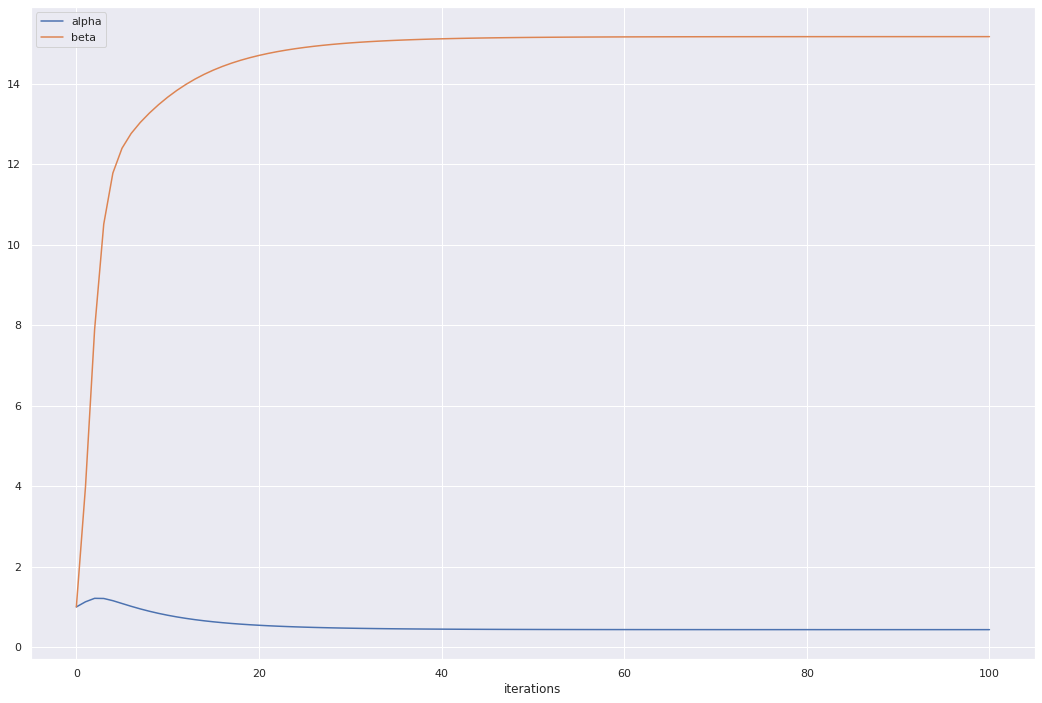

In [4]:
"""
    EM-based Bayesian Linear Regression
    
    This places a zero-mean Gaussian prior on the weights (Essentially L2/Ridge Regularization)
"""
# set sample and features
N = 50 
M = 50

# initialize the alpha/beta parameters 
alpha = 1 # inverse variance of the gaussian prior on the weights
beta = 1 # inverse variance on the additive noise

# create list to record values of alpha/beta
a = list()
b = list()
a.append(alpha)
b.append(beta)

# EM loop
for _ in range(100):
    # Expectation step
    # This finds the mean and covariance matrix on the weight vector
    sigma = np.linalg.inv(beta*np.matmul(X.T,X) + alpha*np.eye(N))
    mu = beta*np.matmul(sigma,np.matmul(X.T,y))

    # Maximization step
    # This finds the inverse variance parameters on weight prior and noise
    # These are closed form solutions derived in (38) and (39) of the Tzikas paper
    alpha = M/(np.linalg.norm(mu)**2 + np.trace(sigma))
    beta = N/(np.linalg.norm(y-np.matmul(X,mu))**2 + np.trace(np.matmul(X.T,np.matmul(sigma,X))))

    # append parameters to lists
    a.append(alpha)
    b.append(beta)
    
# plot alpha and beta
fig, ax = plt.subplots(1,figsize=(18,12))
ax.plot(a, label='alpha')
ax.plot(b, label='beta')
ax.legend()
plt.xlabel('iterations')
plt.show()

# set w_bem to mu (mean of posterior)
sigma = np.linalg.inv(beta*np.matmul(X.T,X) + alpha*np.eye(N))
mu = beta*np.matmul(sigma,np.matmul(X.T,y))
w_bem = mu

# calculate output
y_bem = np.matmul(X,w_bem)

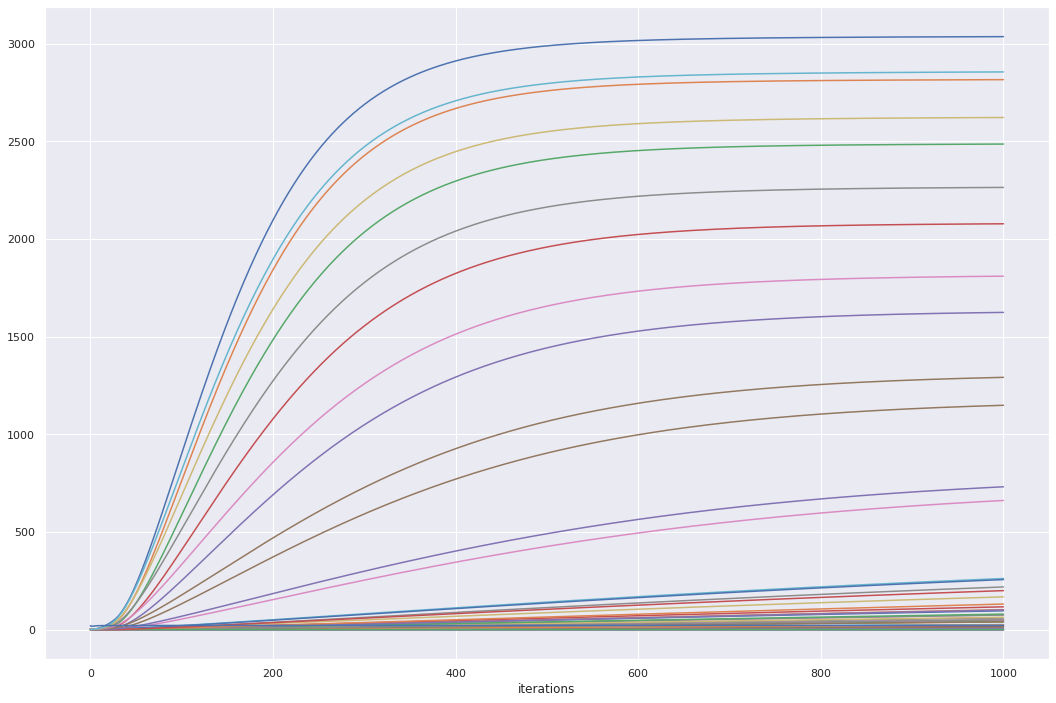

In [5]:
"""
    Variational EM-based Bayesian Linear Regression
    
    In this model, alpha and beta are now latent variables derived from gamma distributions
    
    These new prior distributions are described by parameters a,b,c, and d
    
    In this setup, these parameters are fixed to create an unassuming prior. This means
    that there is only an expectation step.
    
    It is possible to add a maximization step by "unfixining" parameters a,b,c,d
"""
# set sample and features
N = 50
M = 50
Ealpha = np.ones((50,))
Ebeta = 20
a_list = list(); a_list.append(Ealpha)
b_list = list(); b_list.append(Ebeta)
a = 1e-6
b = 1e-6
c = 1e-6
d = 1e-6

# EM loop (see: https://arxiv.org/abs/1301.3838 for derivation of expressions)
for i in range(1000):
    # Expectation Step (No Maximization Step since parameters a,b,c,d are fixed)
    
    # Calc mean and covariance of weight terms
    sigma = np.linalg.inv(Ebeta*np.matmul(X.T,X) + np.diag(Ealpha))
    mu = Ebeta*np.matmul(sigma,np.matmul(X.T,y))
    
    # Calculate parameters on alpha and beta variables
    a_tilde = a + 1/2
    b_tilde = b + (1/2)*(np.diag(sigma) + mu**2)
    c_tilde = c + N/2
    d_tilde = d + (1/2)*np.linalg.norm(y-np.matmul(X,mu))**2

    # Calculate expected value of alpha/beta (mean of gamma distribution)
    Ealpha = a_tilde/b_tilde
    Ebeta = c_tilde/d_tilde

    # append to lists
    a_list.append(Ealpha)
    b_list.append(Ebeta)
    
# plot Expected Value of alpha/beta terms
a_list = np.vstack(a_list)
fig, ax = plt.subplots(1,figsize=(18,12))
ax.plot(a_list)
ax.plot(b_list)
plt.xlabel('iterations')
plt.show()

# get weights
sigma = np.linalg.inv(Ebeta*np.matmul(X.T,X) + np.diag(Ealpha))
mu = Ebeta*np.matmul(sigma,np.matmul(X.T,y))
w_vem = mu

# calculate output
y_vem = np.matmul(X,w_vem)

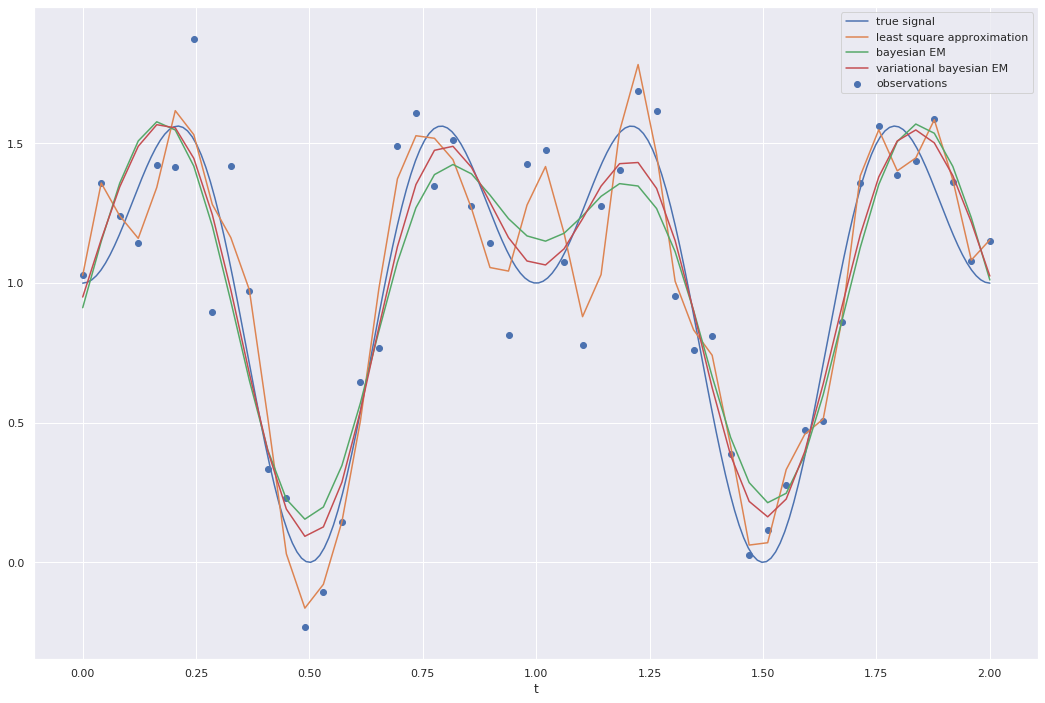

MSE (LS): 1.4833198249822321
MSE (Bayes): 0.7768431195089304
MSE (Variational Bayes): 0.4360061862647408


In [6]:
"""
    Compare regression solutions
"""

# plot outputs
fig, ax = plt.subplots(1,figsize=(18,12))
ax.plot(t, x, label='true signal')
ax.scatter(t_obs, y, label='observations')
ax.plot(t_obs, y_ls, label='least square approximation')
ax.plot(t_obs, y_bem, label='bayesian EM')
ax.plot(t_obs, y_vem, label='variational bayesian EM')
plt.xlabel('t')
ax.legend()
plt.show()

# print MSE to true signal
mse_ls = np.linalg.norm(x[0:200:4] - y_ls)**2
mse_bem = np.linalg.norm(x[0:200:4] - y_bem)**2
mse_vem = np.linalg.norm(x[0:200:4] - y_vem)**2
print("MSE (LS): {}".format(mse_ls))
print("MSE (Bayes): {}".format(mse_bem))
print("MSE (Variational Bayes): {}".format(mse_vem))

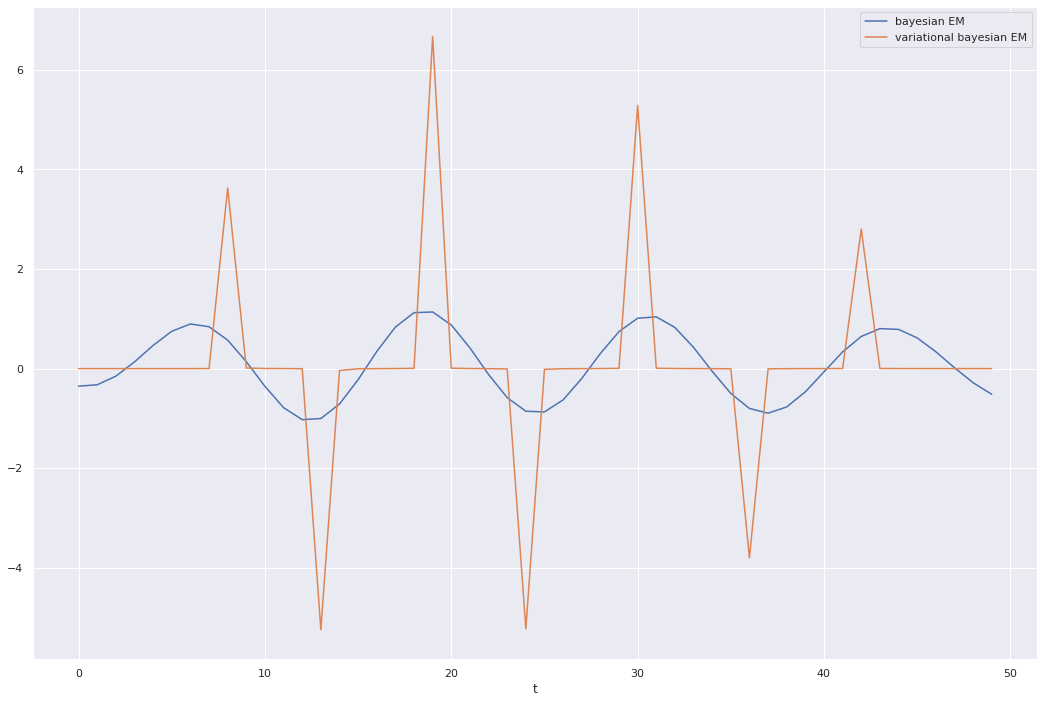

In [7]:
"""
    Compare weights
"""

# plot outputs
fig, ax = plt.subplots(1,figsize=(18,12))
# ax.plot(w_ls, label='least square approximation')
ax.plot(w_bem, label='bayesian EM')
ax.plot(w_vem, label='variational bayesian EM')
plt.xlabel('t')
ax.legend()
plt.show()